In [1]:

# conda create --name torch_env python=3.9
# conda activate torch_env

# conda install -c anaconda ipykernel
# python -m ipykernel install --user --name=torch_env

# conda install -c "nvidia/label/cuda-11.6.0" cuda-toolkit
# pip install torch==1.12.1+cu116 torchvision==0.13.1+cu116 torchaudio==0.12.1 --extra-index-url https://download.pytorch.org/whl/cu116

# python -c "import torch; print(torch.version.cuda)"

# pip install torch-sparse -f https://data.pyg.org/whl/torch-1.12.1+cu116.html
# pip install torch-scatter -f https://data.pyg.org/whl/torch-1.12.1+cu116.html
# pip install torch-geometric
# pip install torch-spline-conv -f https://data.pyg.org/whl/torch-1.12.1+cu116.html
# pip install torch-cluster -f https://data.pyg.org/whl/torch-1.12.1+cu116.html

# pip install pyyaml tomli matplotlib sympy ipywidgets scikit-image


In [2]:
# Helpful statement for debugging, prints the thing entered as x and the output, i.e.,
# debugPrint(1+1) will output '1+1 [int] = 2'
import inspect
import re
def debugPrint(x):
    frame = inspect.currentframe().f_back
    s = inspect.getframeinfo(frame).code_context[0]
    r = re.search(r"\((.*)\)", s).group(1)
    print("{} [{}] = {}".format(r,type(x).__name__, x))
    
    
import os
import os, sys
# sys.path.append(os.path.join('~/dev/pytorchSPH/', "lib"))
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from tqdm import trange, tqdm
import yaml
%matplotlib notebook
import warnings
warnings.filterwarnings(action='once')
from datetime import datetime

import torch
from torch_geometric.nn import radius
from torch_geometric.nn import SplineConv, fps, global_mean_pool, radius_graph, radius
from torch_scatter import scatter

from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

import tomli
from scipy.optimize import minimize
import matplotlib.patches as patches
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.colors import LogNorm
from matplotlib.ticker import MaxNLocator
import matplotlib.ticker as mticker

import torch
# import torchvision.models as models
from torch.profiler import profile, record_function, ProfilerActivity

In [3]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

# Current TODO:
1. ~~Add boundary sampling with particles~~
2. ~~Add offset boundary sampling~~
3. ~~Add akinci-like boundary treatment~~
4. ~~Add mirror pressure term to akinci boundary~~
5. ~~Add MLS pressure term to akinci boundary~~
6. ~~Add body forces to akinci boundary~~
7. Add drag forces to akinci boundary
6. ~~Add Pressure Boundaries approach (maybe)~~
6. ~~Add dense boundary sampling~~
6. ~~Add ghost particle based MLS pressure term in prep for delta sph~~
7. delta sph with fixed ghost particles
8. delta+ sph
9. Add RK4 somehow?!
10. delta sph with boundary integrals?!


# TODO:

1. ~~spherical emission~~
2. ~~adaptive timestepping~~
3. ~~divergence solver~~
4. ~~xsph viscosity~~
5. monaghan viscosity
6. ~~setup dambreak~~
7. setup dambreak with obstacle
8. setup flow past cylinder
9. add wcsph (müller)
10. add compressible sph
11. setup shockwave scenario for compressible sph
12. ~~density solver warm start~~
13. ~~particle shifting~~
14. shifting needs thresholding for free surfaces!! (delta+ sph paper shifting idea based on renormalization vector??)
15. ~~velocityBC~~
16. device integrals for sdf based renormalization matrix
17. ~~rewrite MLS interpolation for stability based on delta+ sph~~
18. ~~improve MLS performance~~
19. ~~improve overall performance~~

In [4]:
from src.simulationBase import SPHSimulation
from src.kernels import kernel, kernelGradient, spikyGrad, wendland, wendlandGrad, cohesionKernel, getKernelFunctions
from src.util import *
from src.module import Module
from src.parameter import Parameter

In [5]:
# import modules to build simulation with
from src.modules.density import densityModule
from src.modules.neighborSearch import neighborSearchModule
from src.modules.akinciTension import akinciTensionModule
from src.modules.sdfBoundary import sdfBoundaryModule, sdPolyDerAndIntegral
from src.modules.akinciBoundary import akinciBoundaryModule
from src.modules.solidBoundary import solidBoundaryModule
from src.modules.periodicBC import periodicBCModule
from src.modules.velocityBC import velocityBCModule
from src.modules.implicitShifting import implicitIterativeShiftModule
from src.modules.gravity import gravityModule
from src.modules.xsph import xsphModule
from src.modules.dfsph import dfsphModule
from src.modules.adaptiveDT import adaptiveTimeSteppingModule

In [6]:
# fig, axis = plt.subplots(2,2, figsize=(9 *  1.09, 9), squeeze = False)
# for axx in axis:
#     for ax in axx:
#         ax.set_xlim(sphSimulation.config['domain']['virtualMin'][0], sphSimulation.config['domain']['virtualMax'][0])
#         ax.set_ylim(sphSimulation.config['domain']['virtualMin'][1], sphSimulation.config['domain']['virtualMax'][1])
#         ax.axis('equal')
#         ax.axvline(sphSimulation.config['domain']['min'][0], ls= '--', c = 'black')
#         ax.axvline(sphSimulation.config['domain']['max'][0], ls= '--', c = 'black')
#         ax.axhline(sphSimulation.config['domain']['min'][1], ls= '--', c = 'black')
#         ax.axhline(sphSimulation.config['domain']['max'][1], ls= '--', c = 'black')

# positions = state['fluidPosition'].detach().cpu().numpy()
# # data = torch.linalg.norm(state['fluidUpdate'].detach(),axis=1).cpu().numpy()
# data = polyDer[:,0].detach().cpu().numpy()


# sc = axis[0,0].scatter(positions[:,0], positions[:,1], c = polyGrad[:,0].detach().cpu().numpy(), s = 4)
# ax1_divider = make_axes_locatable(axis[0,0])
# cax1 = ax1_divider.append_axes("right", size="4%", pad="1%")
# cbar = fig.colorbar(sc, cax=cax1,orientation='vertical')
# cbar.ax.tick_params(labelsize=8) 

In [13]:
class dfsphSimulation(SPHSimulation):    
    def __init__(self, config = tomli.loads('')):
        super().__init__(config)
        
        self.modules = []
        self.moduleParameters = []
        
        if self.verbose: print('Processing modules')
        self.neighborSearch = neighborSearchModule()
        self.sphDensity = densityModule()
        self.periodicBC = periodicBCModule()
        self.DFSPH = dfsphModule()
        self.XSPH = xsphModule()
        self.velocityBC = velocityBCModule()
#         self.shiftModule = implicitIterativeShiftModule()
        self.gravityModule = gravityModule()
        self.adaptiveDT = adaptiveTimeSteppingModule()
        self.surfaceTension = akinciTensionModule()
        
        self.modules.append(self.neighborSearch)
        self.modules.append(self.sphDensity)
        self.modules.append(self.periodicBC)
        self.modules.append(self.velocityBC)
        self.modules.append(self.DFSPH)
        self.modules.append(self.XSPH)
#         self.modules.append(self.shiftModule)
        self.modules.append(self.gravityModule)
        self.modules.append(self.adaptiveDT)
        self.modules.append(self.surfaceTension)    
        if self.config['simulation']['boundaryScheme'] == 'solid': 
            self.boundaryModule = solidBoundaryModule() 
            self.modules.append(self.boundaryModule)  
        if self.config['simulation']['boundaryScheme'] == 'SDF': 
            self.boundaryModule = sdfBoundaryModule() 
            self.modules.append(self.boundaryModule)  
        if self.config['simulation']['boundaryScheme'] == 'Akinci': 
            self.boundaryModule = akinciBoundaryModule() 
            self.modules.append(self.boundaryModule)  
        
        if self.verbose: print('Processing module parameters')
        for module in self.modules:    
            moduleParams =  module.getParameters()
            if moduleParams is not None:
                for param in moduleParams:
                    param.parseConfig(self.config)
                self.moduleParameters = self.moduleParameters + moduleParams
                
    def initializeSimulation(self):
        super().initializeSimulation()
        
        
    def timestep(self):
        step = ' 1 - Enforcing periodic boundary conditions'
        if self.verbose: print(step)
        with record_function(step):
            self.periodicBC.enforcePeriodicBC(self.simulationState, self)
            
        step = ' 2 - Fluid neighborhood search'
        if self.verbose: print(step)
        with record_function(step):
            self.simulationState['fluidNeighbors'], self.simulationState['fluidDistances'], self.simulationState['fluidRadialDistances'] = self.neighborSearch.search(self.simulationState, self)
            
        step = ' 3 - Boundary neighborhood search'
        if self.verbose: print(step)
        with record_function(step):
            self.boundaryModule.boundaryFilterNeighborhoods(self.simulationState, self)
            self.boundaryModule.boundaryNeighborhoodSearch(self.simulationState, self)

        step = ' 4 - Fluid - Fluid density evaluation'
        if self.verbose: print(step)
        with record_function(step):
            self.simulationState['fluidDensity'] = self.sphDensity.evaluate(self.simulationState, self)    
            self.periodicBC.syncQuantity(self.simulationState['fluidDensity'], self.simulationState, self)
        
        step = ' 5 - Fluid - Boundary density evaluation'
        if self.verbose: print(step)
        with record_function(step):
            self.simulationState['fluidDensity'] += self.boundaryModule.evalBoundaryDensity(self.simulationState, self)        
            self.periodicBC.syncQuantity(self.simulationState['fluidDensity'], self.simulationState, self)
            
            
        step = ' 6 - Initializing acceleration'
        if self.verbose: print(step)
        with record_function(step):
            self.simulationState['fluidAcceleration'][:] = 0. 
            
        step = ' 7 - External force evaluation'
        if self.verbose: print(step)
        with record_function(step):
            self.simulationState['fluidAcceleration'] += self.gravityModule.evaluate(self.simulationState, self)
            self.periodicBC.syncQuantity(self.simulationState['fluidAcceleration'], self.simulationState, self)
        
        step = ' 8 - Divergence free solver step'
        if self.verbose: print(step)
        with record_function(step):
            if self.config['dfsph']['divergenceSolver']:
                self.simulationState['divergenceIterations'] = self.DFSPH.divergenceSolver(self.simulationState, self)
                self.periodicBC.syncQuantity(self.simulationState['fluidPredAccel'], self.simulationState, self)
                self.simulationState['fluidAcceleration'] += self.simulationState['fluidPredAccel']

        step = ' 9 - Surface tension force evaluation'
        if self.verbose: print(step)
        with record_function(step):
            sphSimulation.simulationState['fluidNormals'] = self.surfaceTension.computeNormals(sphSimulation.simulationState, sphSimulation)
            self.periodicBC.syncQuantity(self.simulationState['fluidNormals'], self.simulationState, self)
            sphSimulation.simulationState['fluidCohesionForce'] = self.surfaceTension.cohesionForce(sphSimulation.simulationState, sphSimulation)
            sphSimulation.simulationState['fluidCurvatureForce'] = self.surfaceTension.curvatureForce(sphSimulation.simulationState, sphSimulation)
            self.simulationState['fluidAcceleration'] += self.simulationState['fluidCurvatureForce']
            self.simulationState['fluidAcceleration'] += self.simulationState['fluidCohesionForce']
            self.periodicBC.syncQuantity(self.simulationState['fluidAcceleration'], self.simulationState, self)
            
        step = '10 - Incompressible solver step'
        if self.verbose: print(step)
        with record_function(step):
            self.simulationState['densityIterations'] = self.DFSPH.incompressibleSolver(self.simulationState, self)
            self.periodicBC.syncQuantity(self.simulationState['fluidPredAccel'], self.simulationState, self)
            self.simulationState['fluidAcceleration'] += self.simulationState['fluidPredAccel']
            self.periodicBC.syncQuantity(self.simulationState['fluidAcceleration'], self.simulationState, self)
        
        step = '11 - Velocity update step'
        if self.verbose: print(step)
        with record_function(step):
            self.simulationState['fluidVelocity'] += self.simulationState['dt'] * self.simulationState['fluidAcceleration']
            self.periodicBC.syncQuantity(self.simulationState['fluidVelocity'], self.simulationState, self)
        
        step = '12 - XSPH diffusion evaluation'
        if self.verbose: print(step)
        with record_function(step):
            xsphFluidCorrection = self.XSPH.fluidTerm(self.simulationState, self)
            self.periodicBC.syncQuantity(xsphFluidCorrection, self.simulationState, self)
            self.simulationState['fluidVelocity'] += xsphFluidCorrection
        
#         step = ' 1 - Boundary friction evaluation'
#         if self.verbose: print(step)
#         with record_function(step):
#         self.boundaryModule.evalBoundaryFriction(self.simulationState, self)
#         xsphBoundaryCorrection = self.XSPH.boundaryTerm(self.simulationState, self)
#         self.periodicBC.syncQuantity(xsphBoundaryCorrection, self.simulationState, self)
#         self.simulationState['fluidVelocity'] += xsphBoundaryCorrection
        
        step = '13 - Velocity source contribution'
        if self.verbose: print(step)
        with record_function(step):
            self.velocityBC.enforce(self.simulationState, self)
            self.periodicBC.syncQuantity(self.simulationState['fluidVelocity'], self.simulationState, self)
        
        step = '14 - Position update step'
        if self.verbose: print(step)
        with record_function(step):
            self.simulationState['fluidPosition'] += self.simulationState['fluidVelocity'] * self.simulationState['dt']
            
#         step = ' 1 - Shifting positions'
#         if self.verbose: print(step)
#         with record_function(step):
#         self.shiftModule.applyShifting(sphSimulation.simulationState, sphSimulation)
#         self.periodicBC.syncQuantity(self.simulationState['fluidUpdate'], self.simulationState, self)
#         self.simulationState['fluidPosition'] += self.simulationState['fluidUpdate']
        
        step = '15 - Bookkeeping'
        if self.verbose: print(step)
        with record_function(step):
            self.simulationState['time'] += self.simulationState['dt']
            self.simulationState['timestep'] += 1

            self.simulationState['dt'] = self.adaptiveDT.updateTimestep(sphSimulation.simulationState, sphSimulation)

In [14]:
# tomlConfig = """
# [xsph]
# fluidViscosity = 0.01
# boundaryViscosity = 0.01

# [pressure]
# kappa = 1.5
# gamma = 7.0

# [timestep]
# fixed = false
# max = 0.02

# [dfsph]
# minDensitySolverIterations = 2
# minDivergenceSolverIterations = 2
# maxDensitySolverIterations = 256
# maxDivergenceSolverIterations = 8
# densityThreshold = 1e-4
# divergenceThreshold = 1e-2
# divergenceSolver = true
# backgroundPressure = false
# relaxedJacobiOmega = 0.5

# [gravity]
# magnitude = 0
# pointSource = true

# [domain]
# min = [-2, -2]
# max = [2, 2]
# adjustParticle = true
# adjustDomain = true

# [periodicBC]
# periodicX = true
# periodicY = true

# [velocitySources]
# [velocitySources.one]
# min = [1,-2]
# max = [2,2]
# velocity = [0,1]

# [emitter]
# [emitter.fluidBulk]
# fillDomain = false
# min = [-0.5,-0.5]
# max = [0.5, 0.5]
# velocity = [ 0.0, 0.0]
# adjust = true
# """ 

# parsedConfig = tomli.loads(tomlConfig)
# sphSimulation = torchSPH(parsedConfig)

In [15]:
# def evalBoundarySpacing(spacing, support, packing, radius, gamma, plot = False):
#     x = spacing  * support
#     particles = genParticles(torch.tensor([-2*support,x]),torch.tensor([2*support,2* support + x]), radius, packing, support, torch.float32, 'cpu')
#     particleAreas = torch.ones(particles.shape[0]) * (np.pi * radius**2)
# #     particleAreas = torch.ones(particles.shape[0]) * (packing * support)**2
#     if plot:
#         fig, axis = plt.subplots(1,1, figsize=(4 *  1.09, 4), squeeze = False)

#     # axis[0,0].scatter(particles[:,0], particles[:,1], c = 'red',s = 4)

#     centerPosition = torch.tensor([0,0])

#     dists = particles - centerPosition
#     dists = torch.linalg.norm(dists,axis=1)
#     minDist = torch.argmin(dists)
#     centerPosition = particles[minDist]
#     if plot:
#         axis[0,0].scatter(centerPosition[0], centerPosition[1], c = 'blue')

#     minX = -2 * support
#     maxX = 2 * support
#     diff = maxX - minX

#     requiredSlices = int(np.ceil(diff / packing / support))
# #     debugPrint(requiredSlices)
#     xi = torch.arange(requiredSlices).type(torch.float32)
#     yi = torch.tensor([0]).type(torch.float32)
#     xx, yy = torch.meshgrid(xi,yi, indexing = 'xy')

#     bdyPositions = (packing * support) * torch.vstack((xx.flatten(), yy.flatten()))
#     bdyPositions = bdyPositions.mT
#     # debugPrint(bdyPositions)
#     # debugPrint(particles)
#     bdyPositions[:,0] += minX


#     bdyDistances = torch.clamp(torch.linalg.norm(bdyPositions - bdyPositions[:,None], dim = 2) / support, min = 0, max = 1)
#     # debugPrint(kernel(bdyDistances.flatten(), support).reshape(bdyDistances.shape))
#     bdyArea = gamma / torch.sum(kernel(bdyDistances.flatten(), support).reshape(bdyDistances.shape), dim = 0)
#     # debugPrint(bdyKernels.shape)

#     p = torch.vstack((particles, bdyPositions))
#     v = torch.hstack((particleAreas, bdyArea))

#     # p = bdyPositions
#     # v = bdyArea

#     # sc = axis[0,0].scatter(p[:,0], p[:,1], c = v, s =4)
#     # sc = axis[0,0].scatter(bdyPositions[:,0], bdyPositions[:,1], c = bdyKernels, s =4)


#     fluidDistances = torch.clamp(torch.linalg.norm(particles - particles[:,None], dim = 2) / support, min = 0, max = 1)
#     fluidDensity = torch.sum(kernel(fluidDistances, support) * particleAreas[:,None], dim = 0)


#     fluidBdyDistances = torch.clamp(torch.linalg.norm(particles - bdyPositions[:,None], dim = 2) / support, min = 0, max = 1)
#     fluidBdyDensity = torch.sum(kernel(fluidBdyDistances, support) * bdyArea[:, None], dim = 0)


#     centerDensity = fluidDensity[minDist] + fluidBdyDensity[minDist]
#     error = (1 - centerDensity)**2

#     if plot:
#         debugPrint(x)
#         debugPrint(fluidDensity[minDist])
#         debugPrint(fluidBdyDensity[minDist])
#         debugPrint(error)
#         axis[0,0].axis('equal')
#         sc = axis[0,0].scatter(particles[:,0], particles[:,1], c = fluidBdyDensity, s = 4)

#         ax1_divider = make_axes_locatable(axis[0,0])
#         cax1 = ax1_divider.append_axes("right", size="4%", pad="1%")
#         cbar = fig.colorbar(sc, cax=cax1,orientation='vertical')
#         cbar.ax.tick_params(labelsize=8) 
#         sc = axis[0,0].scatter(bdyPositions[:,0], bdyPositions[:,1], c = 'red', s = 4)
#     return error

# support = sphSimulation.config['particle']['support']
# packing = sphSimulation.config['particle']['packing']
# radius = sphSimulation.config['particle']['radius']
# gamma = 0.7

# res = minimize(lambda x: evalBoundarySpacing(x, sphSimulation.config['particle']['support'], sphSimulation.config['particle']['packing'], sphSimulation.config['particle']['radius'], gamma = gamma), 0., method="nelder-mead")
# debugPrint(res.x)

# evalBoundarySpacing(res.x[0], sphSimulation.config['particle']['support'], sphSimulation.config['particle']['packing'], sphSimulation.config['particle']['radius'], gamma = gamma, plot = True)

In [23]:
tomlConfig = """
[xsph]
fluidViscosity = 0.01
boundaryViscosity = 0.01

[pressure]
kappa = 1.5
gamma = 7.0

[timestep]
fixed = false
max = 0.005

[dfsph]
minDensitySolverIterations = 2
minDivergenceSolverIterations = 2
maxDensitySolverIterations = 256
maxDivergenceSolverIterations = 8
densityThreshold = 1e-3
divergenceThreshold = 1e-2
divergenceSolver = false
backgroundPressure = false
relaxedJacobiOmega = 0.5

[domain]
min = [-2, -2]
max = [2, 2]
adjustParticle = true
adjustDomain = true

[periodicBCs]
periodicX = true

[velocitySources]
[velocitySources.one]
min = [1,-2]
max = [2,2]
velocity = [0,1]

[emitter.fluidBulk]
fillDomain = false
min = [-0.5,-2]
max = [0.5,1.0]
velocity = [ 0.0, 0.0]
adjust = true

[emitter2.fluidBulk]
fillDomain = false
min = [-2,-2]
max = [-1.5, -1.5]
velocity = [ 0.0, 0.0]
adjust = true

[compute]
device='cpu'

[particle]
radius = 0.01

[simulation]
boundaryScheme = 'solid'
pressureTerm1 = 'PBSPH'
pressureTerm = 'ghostMLS'
pressureTerm2 = 'deltaMLS'
pressureTerm3 = 'MLSPressure'
verbose = false

[akinciBoundary]
beta = 0.125
gamma = 0.7
""" 

parsedConfig = tomli.loads(tomlConfig)
sphSimulation = dfsphSimulation(parsedConfig)

In [24]:
sphSimulation.initializeSimulation()
# for i in range(11):
# sphSimulation.timestep()

In [25]:
debugPrint(sphSimulation.simulationState['fluidPosition'].shape)

sphSimulation.simulationState['fluidPosition'].shape [Size] = torch.Size([9408, 2])


In [26]:
sphSimulation.timestep()

<IPython.core.display.Javascript object>


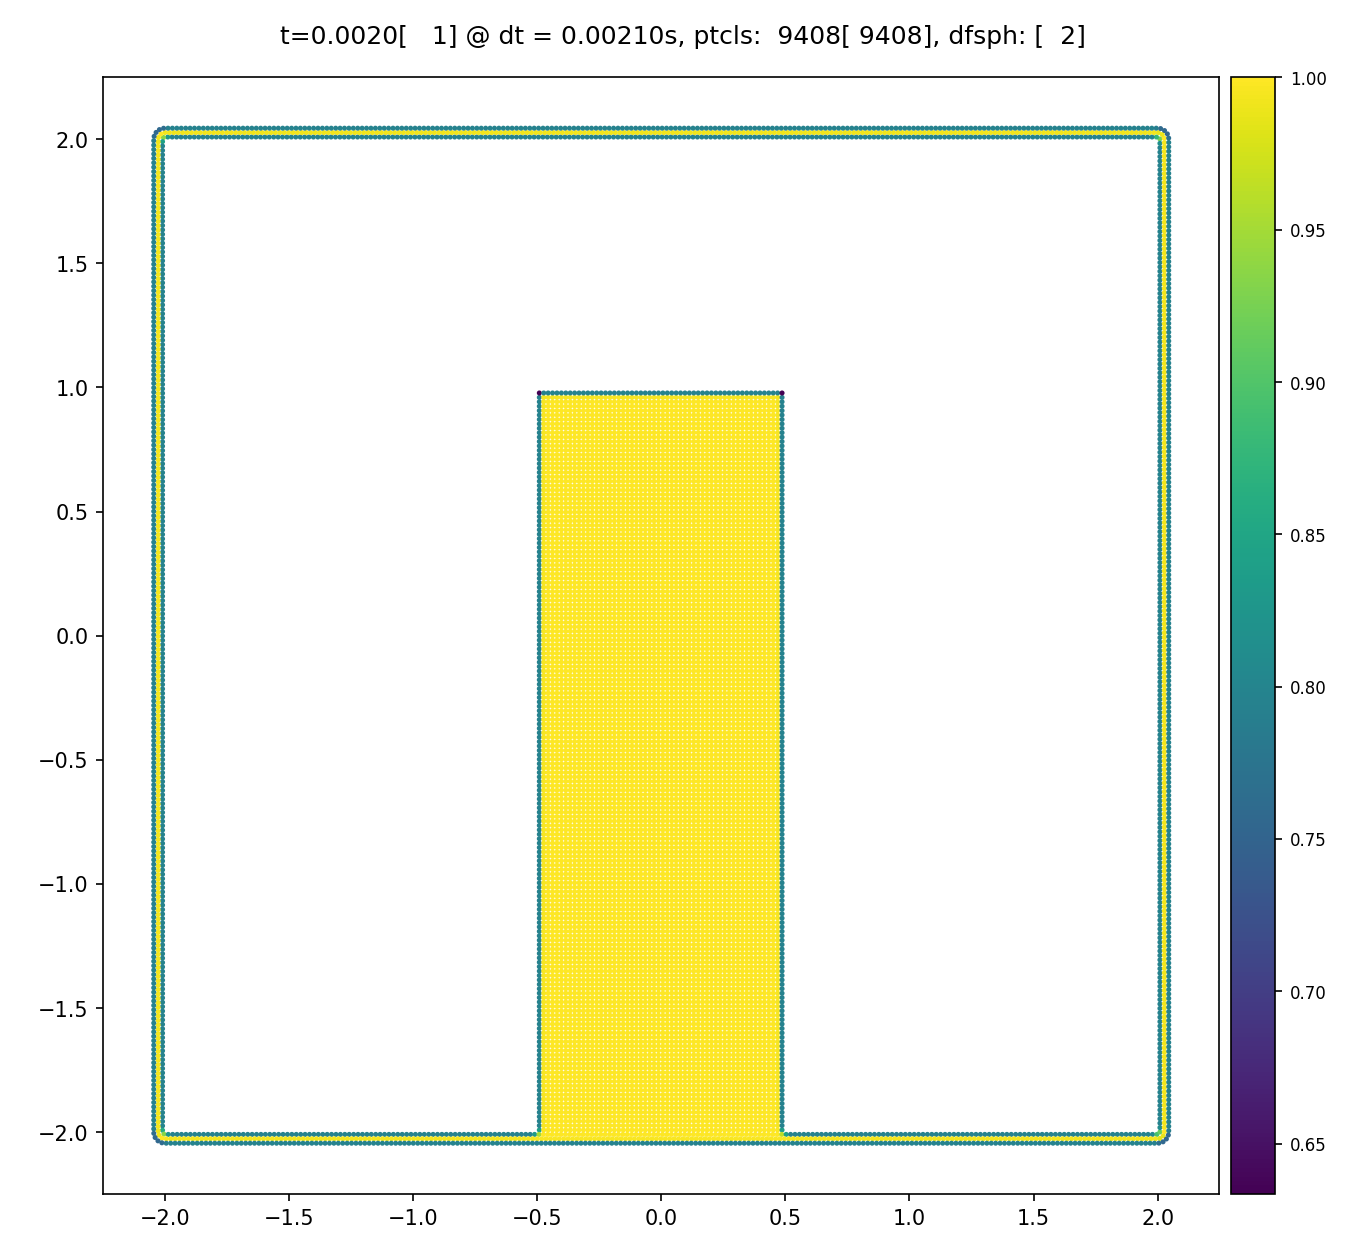

In [27]:

# parsedConfig = tomli.loads(tomlConfig)
# sphSimulation = torchSPH(parsedConfig)
# sphSimulation.initializeSimulation()
# sphSimulation.timestep()

fig, axis = sphSimulation.createPlot(plotScale = 2, plotSolids = False, plotDomain = False)

state = sphSimulation.simulationState


positions = state['fluidPosition'].detach().cpu().numpy()
# data = torch.linalg.norm(state['fluidUpdate'].detach(),axis=1).cpu().numpy()
# data2 = state['akinciBoundary']['boundaryDensity'].detach().cpu().numpy()
data = state['fluidDensity'].detach().cpu().numpy()
# data = state['fluidPressure'].detach().cpu().numpy()
# data = state['residual'].detach().cpu().numpy()
# data = state['fluidDensity'].detach().cpu().numpy()

positions2 = sphSimulation.boundaryModule.boundaryPositions.detach().cpu().numpy()
data2 = sphSimulation.boundaryModule.boundaryDensity.detach().cpu().numpy()

positions = np.vstack((positions, positions2))
data = np.hstack((data, data2))

sc = axis[0,0].scatter(positions[:,0], positions[:,1], c = data, s = 2)
axis[0,0].axis('equal')

ax1_divider = make_axes_locatable(axis[0,0])
cax1 = ax1_divider.append_axes("right", size="4%", pad="1%")
cbar = fig.colorbar(sc, cax=cax1,orientation='vertical')
cbar.ax.tick_params(labelsize=8) 

# quiverData = state['fluidUpdate'].detach().cpu().numpy()
# qv = axis[0,0].quiver(positions[:,0], positions[:,1], quiverData[:,0], quiverData[:,1], \
#                       scale_units='xy', scale = 0.1) #scale = 2/ sphSimulation.config['particle']['support'], alpha=0.5)

# quiverData = state['lambdaGrad'].detach().cpu().numpy()
# qv = axis[0,0].quiver(positions[:,0], positions[:,1], quiverData[:,0], quiverData[:,1], \
#                       scale_units='xy', scale = 2/ sphSimulation.config['particle']['support'], alpha=0.5)


fig.suptitle('t=%2.4f[%4d] @ dt = %1.5fs, ptcls: %5d[%5d]'%(state['time'], state['timestep'], state['dt'],state['numParticles'],state['realParticles']))
if 'densityErrors' in state and not 'divergenceErrors' in state:
    fig.suptitle('t=%2.4f[%4d] @ dt = %1.5fs, ptcls: %5d[%5d], dfsph: [%3d]'%(state['time'], state['timestep'], state['dt'], state['numParticles'],state['realParticles'],len(state['densityErrors'])))
if 'divergenceErrors' in state and not 'densityErrors' in state:
    fig.suptitle('t=%2.4f[%4d] @ dt = %1.5fs, ptcls: %5d[%5d], dfsph: [%3d]'%(state['time'], state['timestep'], state['dt'],state['numParticles'],state['realParticles'],len(state['divergenceErrors'])))
if 'densityErrors' in state and 'divergenceErrors' in state:
    fig.suptitle('t=%2.4f[%4d] @ dt = %1.5fs, ptcls: %5d[%5d], dfsph: [%3d, %3d]'%(state['time'], state['timestep'], state['dt'],state['numParticles'],state['realParticles'],len(state['densityErrors']),len(state['divergenceErrors'])))

fig.tight_layout()



In [16]:
debugPrint(sphSimulation.boundaryModule.boundaryPressure)
debugPrint(torch.min(sphSimulation.boundaryModule.boundaryPressure))
debugPrint(torch.max(sphSimulation.boundaryModule.boundaryPressure))

sphSimulation.boundaryModule.boundaryPressure [Tensor] = tensor([0., 0., 0.,  ..., 0., 0., 0.])
torch.min(sphSimulation.boundaryModule.boundaryPressure) [Tensor] = 0.0
torch.max(sphSimulation.boundaryModule.boundaryPressure) [Tensor] = 65.09584045410156


In [17]:
data = sphSimulation.boundaryModule.boundaryPressure
debugPrint(data)
debugPrint(torch.min(data))
debugPrint(torch.max(data))

data [Tensor] = tensor([0., 0., 0.,  ..., 0., 0., 0.])
torch.min(data) [Tensor] = 0.0
torch.max(data) [Tensor] = 65.09584045410156


In [18]:
torch.arange(data.shape[0])[data == torch.max(data)]

tensor([2407])

In [19]:
i = 1131
debugPrint(sphSimulation.boundaryModule.boundaryDensity[i])
debugPrint(sphSimulation.boundaryModule.boundarySource[i])
debugPrint(sphSimulation.boundaryModule.boundaryAlpha[i])
debugPrint(sphSimulation.boundaryModule.boundaryPressure[i])
debugPrint(sphSimulation.boundaryModule.boundaryPressure2[i])
debugPrint(sphSimulation.boundaryModule.boundaryResidual[i])

sphSimulation.boundaryModule.boundaryDensity[i] [Tensor] = 1.0


AttributeError: 'solidBoundaryModule' object has no attribute 'boundarySource'

In [26]:
bb,bf = sphSimulation.boundaryModule.boundaryToFluidNeighbors
    
boundaryDistances = sphSimulation.boundaryModule.boundaryToFluidNeighborDistances
boundaryRadialDistances = sphSimulation.boundaryModule.boundaryToFluidNeighborRadialDistances
boundaryActualArea = sphSimulation.boundaryModule.boundaryActualArea
boundaryArea = sphSimulation.boundaryModule.boundaryVolume
boundaryRestDensity = sphSimulation.boundaryModule.boundaryRestDensity

grad = spikyGrad(boundaryRadialDistances, boundaryDistances, sphSimulation.boundaryModule.support)
grad2 = torch.einsum('nd, nd -> n', grad, grad)

fluidActualArea = sphSimulation.simulationState['fluidActualArea']
fluidArea = sphSimulation.simulationState['fluidArea']

termFluid = (boundaryActualArea**2 / (boundaryArea * boundaryRestDensity))[bb] * grad2
termBoundary = (sphSimulation.simulationState['fluidActualArea']**2 / (sphSimulation.simulationState['fluidArea'] * sphSimulation.simulationState['fluidRestDensity']))[bf] * grad2
if sphSimulation.boundaryModule.pressureScheme == 'PBSPH':
    kSum1 = scatter(boundaryActualArea[bb,None] * grad, bf, dim=0, dim_size=sphSimulation.simulationState['numParticles'],reduce='add')
    kSum2 = scatter(termFluid, bf, dim=0, dim_size=sphSimulation.simulationState['numParticles'],reduce='add')
    sphSimulation.boundaryModule.boundaryAlpha = torch.clamp(-sphSimulation.simulationState['dt']**2 * boundaryActualArea * scatter(termBoundary, bb, dim=0, dim_size=boundaryArea.shape[0],reduce='add'), max = -0.01**2 * sphSimulation.boundaryModule.support **2)
    
    debugPrint(kSum1[i])
    debugPrint(kSum2[i])
    debugPrint(sphSimulation.boundaryModule.boundaryAlpha[i])
    
    f = bf[bb == i]
    debugPrint(f)

kSum1[i] [Tensor] = tensor([0., 0.])
kSum2[i] [Tensor] = 0.0
sphSimulation.boundaryModule.boundaryAlpha[i] [Tensor] = -1.9849935029014887e-07
f [Tensor] = tensor([], dtype=torch.int64)


sphSimulation.boundaryModule.boundaryDensity[i] [Tensor] = 1.0029523372650146
sphSimulation.boundaryModule.boundarySource[i] [Tensor] = -0.0029523372650146484
sphSimulation.boundaryModule.boundaryAlpha[i] [Tensor] = -0.0
sphSimulation.boundaryModule.boundaryPressure[i] [Tensor] = inf
sphSimulation.boundaryModule.boundaryPressure2[i] [Tensor] = inf
sphSimulation.boundaryModule.boundaryResidual[i] [Tensor] = 0.0029523372650146484


In [20]:
for i in tqdm(range(1024)):
    sphSimulation.timestep()

    
#     positions2 = state['akinciBoundary']['positions'].detach().cpu().numpy()
    # data = torch.linalg.norm(state['fluidUpdate'].detach(),axis=1).cpu().numpy()
#     data2 = state['akinciBoundary']['boundaryDensity'].detach().cpu().numpy()


    positions = state['fluidPosition'].detach().cpu().numpy()
    # data = torch.linalg.norm(state['fluidUpdate'].detach(),axis=1).cpu().numpy()
#     data2 = state['akinciBoundary']['boundaryDensity'].detach().cpu().numpy()
    data = state['fluidDensity'].detach().cpu().numpy()
#     data2 = state['akinciBoundary']['boundaryPressure'].detach().cpu().numpy()
#     data = state['fluidPressure'].detach().cpu().numpy()


#     positions = np.vstack((positions, positions2))
#     data = np.hstack((data, data2))

    positions2 = sphSimulation.boundaryModule.boundaryPositions.detach().cpu().numpy()
    data2 = sphSimulation.boundaryModule.boundaryDensity.detach().cpu().numpy()

    positions = np.vstack((positions, positions2))
    data = np.hstack((data, data2))


    sc.set_offsets(positions)
    sc.set_array(data)
    cbar.mappable.set_clim(vmin=np.min(data), vmax=np.max(data))
    fig.canvas.draw()
    fig.canvas.flush_events()
    fig.suptitle('t=%2.4f[%4d] @ dt = %1.5fs, ptcls: %5d[%5d]'%(state['time'], state['timestep'], state['dt'],state['numParticles'],state['realParticles']))
    if 'densityErrors' in state and not 'divergenceErrors' in state:
        fig.suptitle('t=%2.4f[%4d] @ dt = %1.5fs, ptcls: %5d[%5d], dfsph: [%3d]'%(state['time'], state['timestep'], state['dt'], state['numParticles'],state['realParticles'],len(state['densityErrors'])))
    if 'divergenceErrors' in state and not 'densityErrors' in state:
        fig.suptitle('t=%2.4f[%4d] @ dt = %1.5fs, ptcls: %5d[%5d], dfsph: [%3d]'%(state['time'], state['timestep'], state['dt'],state['numParticles'],state['realParticles'],len(state['divergenceErrors'])))
    if 'densityErrors' in state and 'divergenceErrors' in state:
        fig.suptitle('t=%2.4f[%4d] @ dt = %1.5fs, ptcls: %5d[%5d], dfsph: [%3d, %3d]'%(state['time'], state['timestep'], state['dt'],state['numParticles'],state['realParticles'],len(state['densityErrors']),len(state['divergenceErrors'])))


#     if torch.any(torch.isnan(state['boundaryDensity'])) or torch.any(torch.isnan(state['boundaryGradient'])):
#         raise Exception('Simulation borked')

 20%|██████████████████████████████████▌                                                                                                                                              | 200/1024 [01:42<07:02,  1.95it/s]


KeyboardInterrupt: 

In [10]:
from src.modules.dfsph import *

In [ ]:
debugPrint(state['fluidPosition'])
debugPrint(state['fluidVelocity'])

In [15]:
debugPrint(state['fluidSourceTerm'])
debugPrint(state['fluidDensity'])
debugPrint(state['fluidAlpha'])
debugPrint(state['akinciBoundary']['boundaryToFluidNeighbors'])
debugPrint(state['akinciBoundary']['boundaryToFluidNeighborRadialDistances'])
debugPrint(state['akinciBoundary']['boundaryDensityContribution'])
r = state['akinciBoundary']['boundaryToFluidNeighborRadialDistances']
debugPrint(kernel(r, sphSimulation.DFSPH.support))
# debugPrint(state['akinciBoundary']['boundaryVolume'])

NameError: name 'state' is not defined

In [62]:
debugPrint(state['fluidSourceTerm'])
debugPrint(state['fluidDensity'])
debugPrint(state['fluidAlpha'])
debugPrint(state['akinciBoundary']['boundaryToFluidNeighbors'])
debugPrint(state['akinciBoundary']['boundaryToFluidNeighborRadialDistances'])
debugPrint(state['akinciBoundary']['boundaryDensityContribution'])
r = state['akinciBoundary']['boundaryToFluidNeighborRadialDistances']
debugPrint(kernel(r, sphSimulation.DFSPH.support))
# debugPrint(state['akinciBoundary']['boundaryVolume'])

state['fluidSourceTerm'] [Tensor] = tensor([-0.2424])
state['fluidDensity'] [Tensor] = tensor([0.6411])
state['fluidAlpha'] [Tensor] = tensor([-2.5991e-05])
state['akinciBoundary']['boundaryToFluidNeighbors'] [Tensor] = tensor([[479, 480, 481, 482],
        [  0,   0,   0,   0]])
state['akinciBoundary']['boundaryToFluidNeighborRadialDistances'] [Tensor] = tensor([0.7511, 0.4433, 0.3840, 0.6456])
state['akinciBoundary']['boundaryDensityContribution'] [Tensor] = tensor([0.2911])
kernel(r, sphSimulation.DFSPH.support) [Tensor] = tensor([ 17.1866, 297.8278, 408.4282,  63.1888])


In [20]:
sphSimulation.timestep()

In [16]:
debugPrint(state['fluidSourceTerm'])
debugPrint(state['fluidDensity'])
debugPrint(state['fluidAlpha'])
debugPrint(state['akinciBoundary']['boundaryToFluidNeighbors'])
debugPrint(state['akinciBoundary']['boundaryDensity'])
debugPrint(state['akinciBoundary']['boundaryToFluidNeighborRadialDistances'])
debugPrint(state['akinciBoundary']['boundaryDensityContribution'])
r = state['akinciBoundary']['boundaryToFluidNeighborRadialDistances']
debugPrint(kernel(r, sphSimulation.DFSPH.support))
# debugPrint(state['akinciBoundary']['boundaryVolume'])

state['fluidSourceTerm'] [Tensor] = tensor([0.0031])
state['fluidDensity'] [Tensor] = tensor([0.5296])
state['fluidAlpha'] [Tensor] = tensor([-1.7793e-05])
state['akinciBoundary']['boundaryToFluidNeighbors'] [Tensor] = tensor([[479, 480, 481, 482],
        [  0,   0,   0,   0]])
state['akinciBoundary']['boundaryDensity'] [Tensor] = tensor([0.9595, 0.9595, 0.8812, 0.8652, 0.8965, 0.8999, 0.9000, 0.9000, 0.9000,
        0.9000, 0.9000, 0.9000, 0.9000, 0.9000, 0.9000, 0.9000, 0.9000, 0.9000,
        0.9000, 0.9000, 0.9000, 0.9000, 0.9000, 0.9000, 0.9000, 0.9000, 0.9000,
        0.9000, 0.9000, 0.9000, 0.9000, 0.9000, 0.9000, 0.9000, 0.9000, 0.9000,
        0.9000, 0.9000, 0.9000, 0.9000, 0.9000, 0.9000, 0.9000, 0.9000, 0.9000,
        0.9000, 0.9000, 0.9000, 0.9000, 0.9000, 0.9000, 0.9000, 0.9000, 0.9000,
        0.9000, 0.9000, 0.9000, 0.9000, 0.9000, 0.9000, 0.9000, 0.9000, 0.9000,
        0.9000, 0.9000, 0.9000, 0.9000, 0.9000, 0.9000, 0.9000, 0.9000, 0.9000,
        0.9000, 0.9000, 0.

In [78]:
# debugPrint(torch.any(torch.isnan(sphSimulation.simulationState['akinciBoundary']['M1'])))
# debugPrint(torch.any(torch.isnan(sphSimulation.simulationState['akinciBoundary']['bbar'])))
# debugPrint(sphSimulation.simulationState['akinciBoundary']['bbar'][:,1])
# debugPrint(sphSimulation.simulationState['akinciBoundary']['bbar'][:,2])
# debugPrint(sphSimulation.simulationState['akinciBoundary']['vec'])
# debugPrint(sphSimulation.simulationState['akinciBoundary']['boundaryPressure'])

In [2]:
# debugPrint(sphSimulation.simulationState['fluidSourceTerm'])
# debugPrint(sphSimulation.simulationState['fluidAlpha'])
# debugPrint(sphSimulation.simulationState['fluidPosition'])
# debugPrint(sphSimulation.simulationState['fluidDensity'])
# debugPrint(sphSimulation.simulationState['fluidPressure'])
# debugPrint(sphSimulation.simulationState['fluidResidual'])


In [3]:
# debugPrint(sphSimulation.simulationState['fluidVelocity'])

In [4]:
# @torch.jit.script
# def prepareMLS(boundaryPositions, boundarySupports, neighbors, boundaryRadialDistances, fluidPosition, fluidActualArea, support):

#     # boundaryPositions = state['akinciBoundary']['positions']
#     # boundarySupports = state['akinciBoundary']['boundarySupport']

#     bb = neighbors[0]
#     bf = neighbors[1] #state['akinciBoundary']['boundaryToFluidNeighbors']
#     # boundaryRadialDistances = state['akinciBoundary']['boundaryToFluidNeighborRadialDistances']

#     k = kernel(boundaryRadialDistances, support)* fluidActualArea[bf]

#     nominator = scatter((k)[:,None] * fluidPosition[bf], bb, dim=0, dim_size = boundaryPositions.shape[0], reduce = 'add')
#     denominator = scatter((k), bb, dim=0, dim_size = boundaryPositions.shape[0], reduce = 'add')
#     d = torch.clone(boundaryPositions)
#     d[denominator > 1e-7] = nominator[denominator > 1e-7] / denominator[denominator > 1e-7,None]
#     # debugPrint(state['fluidPosition'][bf] - d[bb])

#     xbar =  fluidPosition[bf] - d[bb]

#     prod = torch.einsum('nu, nv -> nuv', xbar, xbar) * k[:,None,None]

#     Mpartial = scatter(prod, bb, dim = 0, dim_size = boundaryPositions.shape[0], reduce = 'add')

#     M1 = torch.linalg.pinv(Mpartial)

#     vec = xbar * k[:,None]
#     bbar = torch.hstack((torch.ones_like(boundarySupports).unsqueeze(1), boundaryPositions - d))
    
#     return M1, vec, bbar

# @torch.jit.script
# def evalMLS(M1, vec, bbar, neighbors, boundaryRadialDistances, fluidPosition, fluidActualArea, fluidPressure, support):
#     bb = neighbors[0]
#     bf = neighbors[1] 
#     k = kernel(boundaryRadialDistances, support)* fluidActualArea[bf]
    
#     vecSum = scatter(vec * fluidPressure[bf,None], bb, dim = 0, dim_size = M1.shape[0], reduce = 'add')
#     alpha = scatter(fluidPressure[bf] * k, bb, dim = 0, dim_size = M1.shape[0], reduce = 'add') / scatter( k, bb, dim = 0, dim_size = M1.shape[0], reduce = 'add')
#     c = torch.hstack((alpha.unsqueeze(1), torch.matmul(M1, vecSum.unsqueeze(2))[:,:,0]))
#     pb = torch.einsum('nu, nu -> n', bbar, c)
#     return pb

# state['akinciBoundary']['M1'], state['akinciBoundary']['vec'], state['akinciBoundary']['bbar'] = prepareMLS(state['akinciBoundary']['positions'], state['akinciBoundary']['boundarySupport'], state['akinciBoundary']['boundaryToFluidNeighbors'], state['akinciBoundary']['boundaryToFluidNeighborRadialDistances'], state['fluidPosition'], state['fluidActualArea'], sphSimulation.DFSPH.support)
# pb = evalMLS(state['akinciBoundary']['M1'], state['akinciBoundary']['vec'], state['akinciBoundary']['bbar'], state['akinciBoundary']['boundaryToFluidNeighbors'], state['akinciBoundary']['boundaryToFluidNeighborRadialDistances'], state['fluidPosition'], state['fluidActualArea'], state['fluidPressure2'], sphSimulation.DFSPH.support)

# debugPrint(M1.shape)
# debugPrint(vecSum.shape)
# debugPrint(alpha.shape)
# debugPrint(alpha.shape)

# # debugPrint(c.shape)


# debugPrint(pb.shape)
# debugPrint(d.shape)
# debugPrint(boundaryPositions.shape)

In [5]:
# fig, axis = sphSimulation.createPlot(plotScale = 2, plotSolids = False, plotDomain = False)

# state = sphSimulation.simulationState

# positions = state['akinciBoundary']['positions'].detach().cpu().numpy()
# # data = torch.linalg.norm(state['fluidUpdate'].detach(),axis=1).cpu().numpy()
# data2 = state['akinciBoundary']['boundaryPressure'].detach().cpu().numpy()
# data = pb.detach().cpu().numpy()

# sc = axis[0,0].scatter(positions[:,0], positions[:,1], c = 'blue', s = 2)

# sc = axis[0,0].scatter(d[:,0], d[:,1], c = data, s = 2)



In [6]:
# debugPrint(sphSimulation.simulationState['fluidVelocity'][:,0])
# debugPrint(sphSimulation.simulationState['fluidVelocity'][:,1])

In [59]:
sphSimulation.initializeSimulation()
sphSimulation.timestep()

fluidBulk
{'fillDomain': False, 'min': [-1.9910947030991084, -1.9910947030991084], 'max': [-1.5089052969008916, -1.5089052969008916], 'velocity': [0.0, 0.0], 'adjust': True, 'radius': 0.009980802815169677, 'restDensity': 1000, 'type': 'once', 'compression': 1.0, 'shape': 'rectangle'}
Initializing modules


In [ ]:
for i in range(256):
    sphSimulation.timestep()

    
    positions2 = state['akinciBoundary']['positions'].detach().cpu().numpy()
    # data = torch.linalg.norm(state['fluidUpdate'].detach(),axis=1).cpu().numpy()
    data2 = state['akinciBoundary']['boundaryPressure2'].detach().cpu().numpy()


    positions = state['fluidPosition'].detach().cpu().numpy()
    # data = torch.linalg.norm(state['fluidUpdate'].detach(),axis=1).cpu().numpy()
    data = state['fluidPressure'].detach().cpu().numpy()

    positions = np.vstack((positions, positions2))
    data = np.hstack((data, data2))


    sc.set_offsets(positions)
    sc.set_array(data)
    cbar.mappable.set_clim(vmin=np.min(data), vmax=np.max(data))
    fig.canvas.draw()
    fig.canvas.flush_events()
    fig.suptitle('t=%2.4f[%4d] @ dt = %1.5fs, ptcls: %5d[%5d]'%(state['time'], state['timestep'], state['dt'],state['numParticles'],state['realParticles']))
    if 'densityErrors' in state and not 'divergenceErrors' in state:
        fig.suptitle('t=%2.4f[%4d] @ dt = %1.5fs, ptcls: %5d[%5d], dfsph: [%3d]'%(state['time'], state['timestep'], state['dt'], state['numParticles'],state['realParticles'],len(state['densityErrors'])))
    if 'divergenceErrors' in state and not 'densityErrors' in state:
        fig.suptitle('t=%2.4f[%4d] @ dt = %1.5fs, ptcls: %5d[%5d], dfsph: [%3d]'%(state['time'], state['timestep'], state['dt'],state['numParticles'],state['realParticles'],len(state['divergenceErrors'])))
    if 'densityErrors' in state and 'divergenceErrors' in state:
        fig.suptitle('t=%2.4f[%4d] @ dt = %1.5fs, ptcls: %5d[%5d], dfsph: [%3d, %3d]'%(state['time'], state['timestep'], state['dt'],state['numParticles'],state['realParticles'],len(state['densityErrors']),len(state['divergenceErrors'])))


#     if torch.any(torch.isnan(state['boundaryDensity'])) or torch.any(torch.isnan(state['boundaryGradient'])):
#         raise Exception('Simulation borked')

In [ ]:


with profile(activities=[ProfilerActivity.CPU, ProfilerActivity.CUDA],with_stack=False, profile_memory=True) as prof:    
    for i in range(1):
        with record_function("full Timestep"): 
            sphSimulation.timestep()
        
# print(prof.key_averages().table(sort_by='self_cpu_time_total'))
print(prof.key_averages().table(sort_by='cpu_time_total'))

prof.export_chrome_trace("traceGPU.json")